# Notebook 06 — Backtest & Evaluation

This notebook evaluates predictive models **in a trading context** using their out-of-fold (OOF) predictions.  
We simulate simple long/short strategies with strict **t+1 execution** to avoid look-ahead bias.

**Main steps:**
1. **Load data**: Historical prices and OOF predictions (baseline, per-regime, and optional LSTM).
2. **Prepare signals**: Convert predictions to tradable positions with one-day lag.
3. **Backtest**: Apply positions to next-day returns with transaction cost assumptions.
4. **Evaluate performance**:
   - Sharpe Ratio, CAGR, Max Drawdown
   - Hit-rate, Turnover, Volatility, #Trades
5. **Compare models**: Visualize equity curves and summarize metrics.
6. **Sensitivity analysis**: Explore threshold and cost variations (optional).

**Goal:** Determine if predictive skill translates into **profitable, robust trading strategies** under realistic conditions.


## Setup + project paths

In [14]:

import os, sys, json
from pathlib import Path

# Detect Colab
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Mount Drive & set PROJECT_ROOT
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    PROJECT_ROOT = Path("/content/drive/MyDrive/FINAL_PROJECT_MLDL")
else:
    PROJECT_ROOT = Path(".").resolve()

PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)

%cd "$PROJECT_ROOT"

# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
print("SRC_DIR on sys.path:", str(SRC_DIR) in sys.path or str(SRC_DIR) == sys.path[0])

# Folders
CFG_DIR  = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)
print("PROC_DIR:", PROC_DIR)

# Select Asset
ASSET_KEY = "eurusd"

# Colab deps (idempotent)
if IN_COLAB:
    try:
        import pyarrow, sklearn, yaml  # noqa: F401
    except Exception:
        !pip -q install pyarrow scikit-learn pyyaml


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/FINAL_PROJECT_MLDL
/content/drive/MyDrive/FINAL_PROJECT_MLDL
SRC_DIR on sys.path: True
PROC_DIR: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed


## Imports

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import glob


## Load market data & build target returns

In [16]:

def asset_file(stem: str) -> Path:
    """Convenience path for processed files of the current asset."""
    return PROC_DIR / f"{ASSET_KEY}_{stem}.parquet"

aligned = pd.read_parquet(asset_file("aligned")).sort_values("Date").reset_index(drop=True)

# figure out target_Close column
tgt_close_cols = [c for c in aligned.columns if isinstance(c, str) and c.startswith("target_") and c.endswith("_Close")]
if not tgt_close_cols:
    tgt_close_cols = [c for c in aligned.columns if c == "target_Close"]
assert tgt_close_cols, "target close not found"
tgt_col = tgt_close_cols[0]

aligned["ret1"] = aligned[tgt_col].pct_change()    # simple daily return
mkt = aligned[["Date","ret1"]].dropna().reset_index(drop=True)
mkt.head()


,Date,ret1
0,2010-01-04,0.002366
1,2010-01-05,-0.004022
2,2010-01-06,0.002650
3,2010-01-07,-0.005971
4,2010-01-08,0.006499


## Load predictions (OOF)

In [17]:

paths = {
    "baseline": asset_file("baseline_predictions"),
    "per_regime": asset_file("per_regime_signals"),
    "lstm_oof": asset_file("lstm_full_oof"),
}

loaded = {}
for k,p in paths.items():
    if p.exists():
        df = pd.read_parquet(p).sort_values("Date").reset_index(drop=True)
        loaded[k] = df
        print(f"Loaded {k}: {p.name} | shape {df.shape}")
    else:
        print(f"(not found) {k}: {p.name}")


Loaded baseline: eurusd_baseline_predictions.parquet | shape (3851, 3)
Loaded per_regime: eurusd_per_regime_signals.parquet | shape (3851, 5)
Loaded lstm_oof: eurusd_lstm_full_oof.parquet | shape (3851, 2)


## Backtest utilities (one-day lag, costs, metrics)

In [18]:

def to_positions_from_signal(df_sig, col="signal"):
    """
    Convert raw signal {-1, 0, +1} to a lagged position that is tradable at t+1.
    If signal is probability (0..1), you can threshold before passing here.
    """
    pos = df_sig[col].copy()
    # ensure {-1,0,1}
    pos = np.clip(np.sign(pos), -1, 1)
    # enter next day
    return pos.shift(1).fillna(0.0)

def backtest(returns: pd.Series, positions: pd.Series, cost_bps=1.0):
    """
    Simple long/short backtest with linear transaction costs.
    - returns: daily return of the asset (float)
    - positions: daily position {-1,0,1} aligned by Date, will be reindexed
    - cost_bps: cost per trade (round-turn approximated on abs change)
    """
    df = pd.DataFrame({"ret": returns}).copy()
    df["pos"] = positions.reindex(df.index).fillna(0.0).astype(float)
    df["pos_prev"] = df["pos"].shift(1).fillna(0.0)
    df["turnover"] = (df["pos"] - df["pos_prev"]).abs()
    tc = cost_bps * 1e-4   # convert bps to decimal
    df["pnl_gross"] = df["pos_prev"] * df["ret"]      # position applied to next day's return
    df["pnl_cost"]  = df["turnover"] * tc
    df["pnl"] = df["pnl_gross"] - df["pnl_cost"]

    # metrics
    cum = (1.0 + df["pnl"]).cumprod()
    equity = cum / cum.iloc[0]
    dd = equity / equity.cummax() - 1.0
    m = {}
    m["CAGR"]   = equity.iloc[-1] ** (252/len(equity)) - 1
    m["Vol"]    = df["pnl"].std() * np.sqrt(252)
    m["Sharpe"] = (df["pnl"].mean() / (df["pnl"].std() + 1e-12)) * np.sqrt(252)
    m["MDD"]    = dd.min()
    m["Hit"]    = (df["pnl"] > 0).mean()
    m["Turn"]   = df["turnover"].mean() * 252
    m["Trades"] = int(df["turnover"].sum()/2)  # rough count (changes / 2)
    out = pd.Series(m).to_frame("value")
    return df, equity, dd, out

def plot_equity(curves: dict, title="Equity curves"):
    plt.figure(figsize=(10,5))
    for name, s in curves.items():
        plt.plot(s.index, s.values, label=name)
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Equity (1.0 = start)")
    plt.legend(); plt.tight_layout(); plt.show()


## Strategy definitions for each model family

In [19]:

results = {}
curves  = {}

# Baseline (already has 'signal' or probabilities)
if "baseline" in loaded:
    base = (loaded["baseline"]
            .merge(mkt, on="Date", how="inner")
            .dropna(subset=["ret1"])
            .sort_values("Date"))
    # If both prob and signal exist, prefer provided signal; else derive from prob>=0.5
    if "signal" in base.columns:
        sig = base["signal"]
    else:
        prob_cols = [c for c in base.columns if c.startswith("oof_") or "prob" in c]
        assert prob_cols, "No prob/signal column found for baseline."
        sig = (base[prob_cols[0]] >= 0.5).astype(int).replace({0:-1,1:1})
    pos = to_positions_from_signal(base.assign(signal=sig), col="signal")
    bt, eq, dd, met = backtest(base["ret1"], pos, cost_bps=1.0)
    results["baseline"] = met["value"]
    curves["baseline"]  = (1+bt["pnl"]).cumprod()
    print("Baseline metrics:\n", met.T.round(3))

# Per-regime (comes with 'oof_prob' and 'signal')
if "per_regime" in loaded:
    reg = (loaded["per_regime"]
           .merge(mkt, on="Date", how="inner")
           .dropna(subset=["ret1"])
           .sort_values("Date"))
    # threshold at 0.5 by default
    if "signal" not in reg.columns:
        reg["signal"] = np.where(reg["oof_prob"] >= 0.5, 1, -1)
    pos = to_positions_from_signal(reg, col="signal")
    bt, eq, dd, met = backtest(reg["ret1"], pos, cost_bps=1.0)
    results["per_regime"] = met["value"]
    curves["per_regime"]  = (1+bt["pnl"]).cumprod()
    print("Per-regime metrics:\n", met.T.round(3))

# LSTM (probabilities only; grid threshold or 0.5)
if "lstm_oof" in loaded:
    lstm = (loaded["lstm_oof"]
            .merge(mkt, on="Date", how="inner")
            .dropna(subset=["ret1"])
            .sort_values("Date"))
    # Simple 0.5 threshold; feel free to grid-search below
    lstm["signal"] = np.where(lstm["prob_up_oof"] >= 0.5, 1, -1)
    pos = to_positions_from_signal(lstm, col="signal")
    bt, eq, dd, met = backtest(lstm["ret1"], pos, cost_bps=1.0)
    results["lstm_0p5"] = met["value"]
    curves["lstm_0p5"]  = (1+bt["pnl"]).cumprod()
    print("LSTM (0.5 thr) metrics:\n", met.T.round(3))


Baseline metrics:
         CAGR    Vol  Sharpe   MDD    Hit     Turn  Trades
value -0.045  0.086  -0.493 -0.57  0.476  218.758  1671.0
Per-regime metrics:
        CAGR    Vol  Sharpe    MDD    Hit     Turn  Trades
value -0.04  0.086  -0.438 -0.613  0.477  212.476  1623.0
LSTM (0.5 thr) metrics:
         CAGR    Vol  Sharpe    MDD    Hit   Turn  Trades
value  0.012  0.085   0.188 -0.267  0.499  9.619    73.0


## Threshold & cost sensitivity (optional)
### Only for LSTM or per_regime with 'oof_prob'

In [20]:

sens_rows = []
if "lstm_oof" in loaded:
    probs = (loaded["lstm_oof"]
             .merge(mkt, on="Date", how="inner")
             .dropna(subset=["ret1"])
             .sort_values("Date"))
    for thr in np.linspace(0.45, 0.55, 5):
        for bps in [0.0, 0.5, 1.0, 2.0]:
            probs["signal"] = np.where(probs["prob_up_oof"] >= thr, 1, -1)
            pos = to_positions_from_signal(probs, "signal")
            _, _, _, met = backtest(probs["ret1"], pos, cost_bps=bps)
            sens_rows.append({"model":"lstm", "thr":thr, "bps":bps, **met["value"].to_dict()})
sens_df = pd.DataFrame(sens_rows)
if len(sens_df):
    display(sens_df.sort_values("Sharpe", ascending=False).head(10).round(3))


,model,thr,bps,CAGR,Vol,Sharpe,MDD,Hit,Turn,Trades
4,lstm,0.475,0.0,0.015,0.085,0.219,-0.271,0.500,9.358,71.0
5,lstm,0.475,0.5,0.015,0.085,0.214,-0.271,0.500,9.358,71.0
6,lstm,0.475,1.0,0.014,0.085,0.208,-0.271,0.500,9.358,71.0
16,lstm,0.550,0.0,0.014,0.085,0.204,-0.214,0.499,19.042,145.0
8,lstm,0.500,0.0,0.013,0.085,0.199,-0.267,0.499,9.619,73.0
7,lstm,0.475,2.0,0.013,0.085,0.197,-0.271,0.500,9.358,71.0
12,lstm,0.525,0.0,0.013,0.085,0.197,-0.283,0.498,14.331,109.0
9,lstm,0.500,0.5,0.013,0.085,0.193,-0.267,0.499,9.619,73.0
17,lstm,0.550,0.5,0.013,0.085,0.193,-0.217,0.499,19.042,145.0
13,lstm,0.525,0.5,0.012,0.085,0.188,-0.284,0.498,14.331,109.0


## Compare curves & metrics

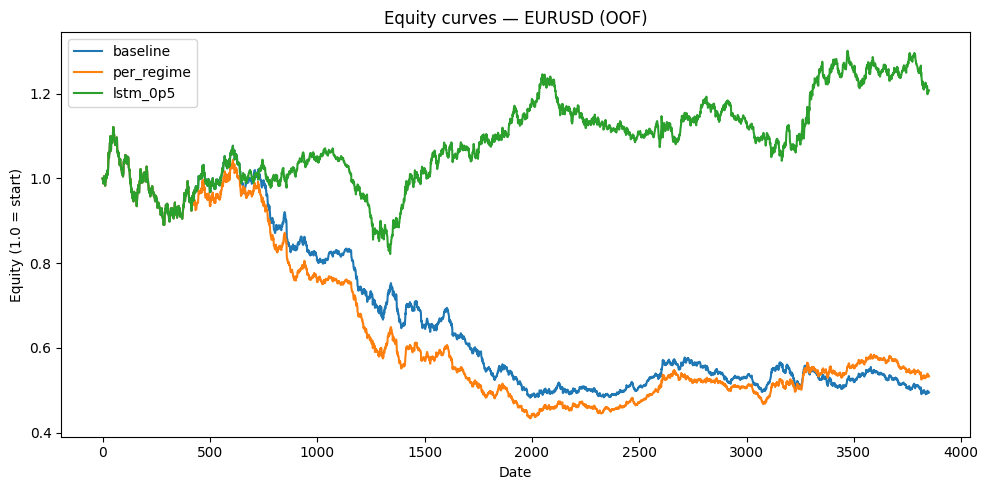

,CAGR,Sharpe,Vol,MDD,Hit,Turn,Trades
lstm_0p5,0.012,0.188,0.085,-0.267,0.499,9.619,73.0
per_regime,-0.040,-0.438,0.086,-0.613,0.477,212.476,1623.0
baseline,-0.045,-0.493,0.086,-0.570,0.476,218.758,1671.0


In [21]:

if curves:
    plot_equity(curves, title=f"Equity curves — {ASSET_KEY.upper()} (OOF)")
    perf = pd.DataFrame(results).T[["CAGR","Sharpe","Vol","MDD","Hit","Turn","Trades"]].round(3)
    display(perf.sort_values("Sharpe", ascending=False))
else:
    print("No curves to plot — make sure upstream predictions exist.")


## Save comparison to disk

In [22]:

if curves:
    # Save equity curves
    eq_tbl = pd.DataFrame({"Date": mkt["Date"]})
    for k,v in curves.items():
        eq_tbl[k] = v.values[-len(eq_tbl):] if len(v) >= len(eq_tbl) else np.nan
    eq_tbl.to_parquet(asset_file("bt_equity_curves"), index=False)

    # Save metrics
    perf = pd.DataFrame(results).T
    perf.to_parquet(asset_file("bt_metrics"), index=True)
    print("Saved:", asset_file("bt_equity_curves").name, "|", asset_file("bt_metrics").name)


Saved: eurusd_bt_equity_curves.parquet | eurusd_bt_metrics.parquet
